## Static Network

### Import Modules

In [1]:
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
from scipy.optimize import minimize
from scipy import stats
from collections import deque
import networkx as nx
import math as m

### Network Initialize

In [29]:
size_list = [1000, 5000, 10000, 50000, 100000]
mean_degree = int(input("Target Mean Degree : ").strip())
gamma = float(input("Degree Exponent(gamma) : ").strip())

Target Mean Degree : 100
Degree Exponent(gamma) : 5


## Static Network Class

In [30]:
class STATIC:
    def __init__(self, mean_degree, gamma, size_list=[]):
        self.gamma = gamma
        self.mean_degree = mean_degree
        self.size_list = size_list
        self.degree = dict()
        self.adjacent = dict()
        self.num_of_links = dict()
        self.weight = dict()
        
        for size in self.size_list:
            self.degree[size]=dict()
            self.adjacent[size]=dict()
            self.num_of_links[size] = 0
            self.weight[size] = []
            
        self.largest_cluster = []
        
    @staticmethod
    def power_law(x, a, b):
        return b * np.power(x, a)
    
    @staticmethod
    def log_binning(data, start, length):
        maxbin = m.ceil(np.log10(max(data)))
        hist, bins = np.histogram(data, bins=np.logspace(start, maxbin, num=length, endpoint=True, base=10.0))
        bin_centers = (bins[1:] + bins[:-1]) * 0.5
        delt = bins[1:] - bins[:-1]
        # print(maxbin, delt, sum(hist))
        hist = hist / delt / sum(hist)
        return bin_centers, hist
    
    def generate(self):
        ## Generate Weight ##
        alpha = 1.0 / (self.gamma - 1.0)
        self.weight = [pow(i + 1, -alpha) for i in range(self.size)]
        prob = np.array(list(self.weight)) / sum(list(self.weight))
        nodes = [i for i in range(self.size)]
        for node in range(self.size):
            self.degree[node] = 0
            self.adjacent[node] = []
        
        ## Generate Static ##
        for self.num_of_links in tqdm(range(int(self.size * self.mean_degree / 2.0))):       
            node1, node2 = np.random.choice(nodes, 2, p=prob)
            link_check = 0
            for i in range(self.degree[node1]):
                if self.adjacent[node1][i] == node2:
                    link_check = 1
                    break
            
            if link_check == 0:
                self.degree[node1] += 1
                self.degree[node2] += 1

                if node1 in self.adjacent.keys():
                    self.adjacent[node1].append(node2)
                else:
                    self.adjacent[node1] = [node2]
                
                if node2 in self.adjacent.keys():
                    self.adjacent[node2].append(node1)
                else:
                    self.adjacent[node2] = [node1]
                    
                self.num_of_links += 1
                
    def fast_generate(self):
        for size in self.size_list:
            alpha = 1.0 / (self.gamma - 1.0)
            self.weight[size] = [pow(i + 1, -alpha) for i in range(size)]
            prob = np.array(list(self.weight[size])) / sum(list(self.weight[size]))
            nodes = [i for i in range(size)]

            link_max = int(size * self.mean_degree / 2.0)
            samples = np.random.choice(nodes, p=prob, size=link_max*4).reshape(-1, 2)
            print(samples.shape, link_max)
            idx_filter = (samples[:, 0] - samples[:, 1]).astype(bool)
            samples = samples[idx_filter][:link_max]
            print(samples.shape, link_max)
            samples = np.unique(samples, axis=0)
            print(samples.shape)

            for node in range(size):
                self.adjacent[size][node] = []
                self.degree[size][node] = 0

            for node1, node2 in tqdm(samples):
                if node2 not in self.adjacent[size][node1]:
                    self.degree[size][node1] += 1
                    self.adjacent[size][node1].append(node2)
                
    def plot_degree_dist(self):
        dat = sorted(self.degree.values(), reverse=False)
        plt.figure(figsize=(10, 6))
        sns.countplot(dat)
        plt.show()
    
    def loglog_plot(self, cutoff):
        fig = plt.figure(figsize=(10, 8), facecolor=(0.9, 0.9, 0.9))
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('degree')
        plt.ylabel('distribution')
        plt.xlim(10000, 1000000000)
        plt.ylim(0.00001,100)
        plt.grid()
                                                   
        for enum, size in enumerate(self.size_list):
            enum += 1
            dat = sorted(self.degree[size].values(), reverse=False)

            x_bin, y_bin = self.log_binning(dat, 0, 30)
            sum_y = sum(y_bin)
            data = dict()
            for x, y in zip(x_bin, y_bin):
                data[x] = y

            data0 = dict()

            for item in dat:
                if item in data0.keys():
                    data0[item] += 1
                else:
                    data0[item] = 1

            data_buf = sorted(data0.items(), key=lambda x:x[0], reverse=False)   
            x0 = np.array(list(map(lambda x:x[0], data_buf)))
            y0 = np.array(list(map(lambda x:x[1], data_buf)))
            sum_y0 = sum(y0)
            y0 = y0 / sum_y0

            cum = dict()

            for key, val in zip(x_bin, y_bin):
                buf = x_bin[x_bin >= key]
                for item in buf:
                    if key in cum.keys():
                        cum[key] += data[item]
                    else:
                        cum[key] = data[item]

            x_2 = np.array(list(cum.keys()))
            y_2 = np.array(list(cum.values()))
            y_2 = y_2 / sum(y_2)


            popt, pcov = curve_fit(self.power_law, xdata=x_2[cutoff:], ydata=y_2[cutoff:], method='dogbox')
    
            #plt.scatter(x_bin[9:] * size * 2, y_bin[9:], s=55.0, marker='o', color=(1.0 / enum,0.0,1.0 / enum), alpha=1.0, edgecolors=(0.0,0.0,0.0), label="BA Network, size=" + str(size), zorder=2)
            plt.scatter(x_2[cutoff:] * size * 2, y_2[cutoff:] * 10, s=55.0, marker='o', color=(0.0,1.0 / enum,1.0 / enum), alpha=1.0, edgecolors=(0.0,0.0,0.0), label="Size=" + str(size), zorder=2)
            #plt.scatter(x0[9:] * size * 2, y0[9:], s=55.0, marker='o', color=(1.0 / enum,1.0 / enum,0.0), alpha=1.0, edgecolors=(0.0,0.0,0.0), label="Raw BA Network , size=" + str(size), zorder=2)
            if size==max(self.size_list):
                plt.scatter(x_2 * size * 2, self.power_law(x_2, *popt) * 100, s=55.0, marker='o', color=(1.0,1.0,1.0), alpha=1.0, edgecolors=(0.0,0.0,0.0), label="gamma="+str(-popt[0]), zorder=2)
                plt.plot(x_2 * size * 2, self.power_law(x_2, *popt) * 100, c=(1.0,0.0,0.0), zorder=1)
        
        plt.legend()
        plt.show()
        fig.savefig("./static.png")
    
    def bfs2(self, start):
        # keep track of all visited nodes
        explored = []
        # keep track of nodes to be checked
        queue = [start]

        # keep looping until there are nodes still to be checked
        while queue:
            # pop shallowest node (first node) from queue
            node = queue.pop(0)
            if node not in explored:
                # add node to list of checked nodes
                explored.append(node)
                neighbours = self.adjacent[node]

                # add neighbours of node to queue
                for neighbour in neighbours:
                    queue.append(neighbour)
        return explored
    
    def bfs(self, root):
        visited = []
        queue = deque([root])

        while queue:
            n = queue.popleft()
            if n not in visited:
                visited.append(n)
                queue += set(self.adjacent[n]) - set(visited)
        return visited
    
    def bfs3(self, root):
        visited = []
        buf = self.adjacent[root]
        
        while buf:
            n = buf.pop(0)
            
            if n not in visited:
                visited.append(n)
                buf += list(set(self.adjacent[n]) - set(visited))
                
        return visited
    
    def burning(self):
        max_length = 0
        for node in tqdm(range(self.size)):
            buf = self.bfs3(node)
            if len(buf) > max_length:
                max_length = len(buf)
                self.largest_cluster = buf     

In [31]:
static = STATIC(mean_degree, gamma, size_list)

In [32]:
static.fast_generate()

 36%|████████████████████▎                                   | 17618/48489 [00:00<00:00, 174459.82it/s]

(100000, 2) 50000
(50000, 2) 50000
(48489, 2)


100%|████████████████████████████████████████████████████████| 48489/48489 [00:00<00:00, 177636.02it/s]


(500000, 2) 250000
(250000, 2) 250000


  6%|███▍                                                   | 15467/248448 [00:00<00:01, 154644.71it/s]

(248448, 2)


100%|██████████████████████████████████████████████████████| 248448/248448 [00:01<00:00, 178998.53it/s]


(1000000, 2) 500000
(500000, 2) 500000


  3%|█▌                                                     | 13984/498475 [00:00<00:03, 138495.89it/s]

(498475, 2)


100%|██████████████████████████████████████████████████████| 498475/498475 [00:02<00:00, 182260.91it/s]


(5000000, 2) 2500000
(2500000, 2) 2500000


  0%|▏                                                     | 11099/2498492 [00:00<00:22, 109892.83it/s]

(2498492, 2)


100%|████████████████████████████████████████████████████| 2498492/2498492 [00:13<00:00, 182706.19it/s]


(10000000, 2) 5000000
(5000000, 2) 5000000


  0%|                                                                      | 0/4998382 [00:00<?, ?it/s]

(4998382, 2)


100%|████████████████████████████████████████████████████| 4998382/4998382 [00:27<00:00, 181227.09it/s]


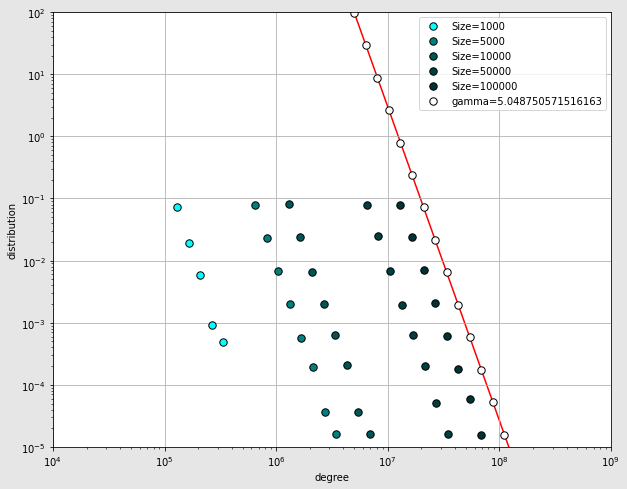

In [40]:
static.loglog_plot(cutoff=17)